In this notebook, we are going to build a neural network(multilayer perceptron) using numpy and successfully train it to recognize digits in the image. Deep learning is a vast topic, but we got to start somewhere, so let's start with the very basics of a neural network which is Multilayer Perceptron. 

## What is a neural network?
A neural network is a type of machine learning model which is inspired by our neurons in the brain where many neurons are connected with many other neurons to translate an input to an output (simple right?). Mostly we can look at any machine learning model and think of it as a function which takes an input and produces the desired output; it's the same with a neural network.

## What is a Multi layer perceptron?

Multi-layer perceptron is a type of network where multiple layers of a group of perceptron are stacked together to make a model. Before we jump into the concept of a layer and multiple perceptrons, let's start with the building block of this network which is a perceptron. Think of perceptron/neuron as a linear model which takes multiple inputs and produce an output. In our case perceptron is a linear model which takes a bunch of inputs multiply them with weights and add a bias term to generate an output.<br/>
<center>$Z= \vec{w} \cdot X + {b}$<center> <br/>
<img src="https://raw.githubusercontent.com/aayushmnit/Deep_learning_explorations/master/1_MLP_from_scratch/perceptron.png" align='center'>
<center>*Fig 1: Perceptron image*<center> <br/>
<div align='right'>*Image credit=https://commons.wikimedia.org/wiki/File:Perceptron.png/*</div>

Now, if we stack a bunch of these perceptrons together, it becomes a hidden layer which is also known as a Dense layer in modern deep learning terminology. <br/>
<center>**Dense layer,** $f(X)=W \cdot X + \vec{b}$</center> <br/>
*Note that bias term is now a vector and W is a weight matrix* <br/>
<img src="https://raw.githubusercontent.com/aayushmnit/Deep_learning_explorations/master/1_MLP_from_scratch/single_layer_mlp.png" align ='center'>
<center>***Fig: Single dense layer perceptron network***<center> <br/>
<div align='right'>*Image credit=http://www.texample.net/tikz/examples/neural-network/*</div>

Now we understand dense layer let's add a bunch of them, and that network becomes a multi-layer perceptron network.

<img src="https://raw.githubusercontent.com/aayushmnit/Deep_learning_explorations/master/1_MLP_from_scratch/multi_layer_mlp.png" align ='center'>
<center>***Fig: Multi layer perceptron network***<center> <br/>
<div align='right'> *Image credit=http://pubs.sciepub.com/ajmm/3/3/1/figure/2*</div>    

If you have noticed our dense layer, only have linear functions, and any combination of linear function only results in the linear output. As we want our MLP to be flexible and learn non-linear decision boundaries, we also need to introduce non-linearity into the network. We achieve the task of introducing non-linearity by adding activation function. There are various kinds of activation function which can be used, but we will be implementing Rectified Linear Units(ReLu) which is one of the popular activation function. ReLU function is a simple function which is zero for any input value below zero and the same value for values greater than zero. <br/>
<center>**ReLU function ** $f(X) = max(0,X)$</center>
<br/>
Now, we understand dense layer and also understand the purpose of activation function, the only thing left is training the network. For training a neural network we need to have a loss function and every layer should have a **feed-forward loop** and **backpropagation loop**. Feedforward loop takes an input and generates output for making a prediction and backpropagation loop helps in training the model by adjusting weights in the layer to lower the output loss. In backpropagation, the weight update is done by using backpropagated gradients using the chain rule and optimized using an optimization algorithm. In our case, we will be using SGD(stochastic gradient descent). If you don't understand the concept of gradient weight updates and SGD, I recommend you to watch [week 1 of Machine learning by Andrew NG lectures](https://www.coursera.org/ml).

So, to summarize a neural network needs few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other activation function to introduce non-linearity)
- Loss function - (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

## Coding Starts here --

Let's start by importing some libraires required for creating our neural network.

In [2]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass *.forward()* and Backward pass *.backward().*

In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units) # faz uma matriz com a diagonal seguindo o array num_units?
        
        return np.dot(grad_output, d_layer_d_input) # chain rule  multiplicaçao de matrizes

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input) # se o valor for menor que 0 recebe 0 (basicamente impede negativos)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad # pelo oq entendi se o input for menor que zero o backward é 0

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        # iniciando os pesos com a media 0 e uma variance de 2/(number of inputs + number of outputs) 
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases # multiplicando o input com os pesos depois somando a bias
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)  # multiplicando o grad_output pela transposiçao dos pesos
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0] # calcular a media pelas colunas do grad_output e * pelo tamanho do input
        
        # retorna erro se essas condiçoes forem falsas
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [6]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. As I have told earlier, we are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Using TensorFlow backend.


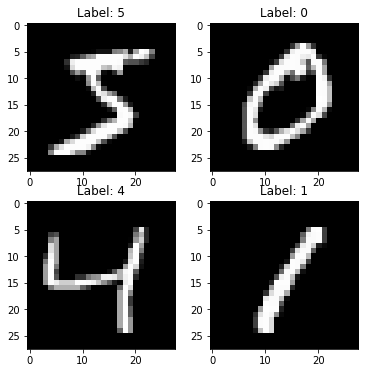

In [7]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [8]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [9]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]: # um loop do maior pro menor, ou seja 10 9 8, etc
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

backpropagation training.

https://www.youtube.com/watch?v=IjdJNPpJ8nE
1- Iniciar os pesos (w) com valores arbitrarios não nulos.
2- Propagar uma entrada #x ate a saida da rede y.
3- Calcular erro (e) e delta (δ) de cada neuronio de saida.
4- Ajustar pesos em cada neuronio de saida.
5- Calcular delta (δ) de cada neuronios da ultima camada oculta.
6- Ajustar pesos de cada neuronio da ultima camada oculta.
7- Repetir passos 5 e 6 na primeira camada oculta.
8- Repetir passos 2 até 7 para cada entrada #x do treinamento.
9- Criterio de parada do algoritmo backpropagation.
    - Limite de épocas; ou.
    - Atingir erro quadratico medio desejado.

In [10]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [11]:
from IPython.display import clear_output
train_log = []
val_log = []

In [ ]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

  7%|▋         | 103/1562 [00:01<00:15, 96.53it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\luizg\Anaconda3\envs\keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\luizg\AppData\Local\Temp/ipykernel_24596/2940784082.py", line 4, in <module>
    train(network,x_batch,y_batch)
  File "C:\Users\luizg\AppData\Local\Temp/ipykernel_24596/1545107408.py", line 34, in train
    layer_activations = forward(network,X)
  File "C:\Users\luizg\AppData\Local\Temp/ipykernel_24596/1545107408.py", line 11, in forward
    activations.append(l.forward(input))
  File "C:\Users\luizg\AppData\Local\Temp/ipykernel_24596/3976541833.py", line 22, in forward
    return np.dot(input,self.weights) + self.biases # multiplicando o input com os pesos depois somando a bias
  File "<__array_function__ internals>", line 6, in dot
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fi

As we can see we have successfully trained a MLP which was purely written in numpy with high validation accuracy!